# Role-Playing Scraper for Report & Knowledge Graph Generation


You can also check this cookbook in colab [here](https://colab.research.google.com/drive/1XN18zb5ay97ju8LvL7WikEDqQBws-t0U?usp=sharing)

⭐ <i>Star us on [*Github*](https://github.com/camel-ai/camel), join our [*Discord*](https://discord.camel-ai.org) or follow our [*X*](https://x.com/camelaiorg)

This notebook demonstrates how to set up and leverage CAMEL's Retrieval-Augmented Generation (RAG) combined with Firecrawl for efficient web scraping, multi-agent role-playing tasks, and knowledge graph construction. We will walk through an example of conducting a comprehensive study of the Turkish shooter in the 2024 Paris Olympics by using Mistral's models.

In this notebook, you'll explore:

*   **CAMEL**: A powerful multi-agent framework that enables Retrieval-Augmented Generation and multi-agent role-playing scenarios, allowing for sophisticated AI-driven tasks.
*   **Mistral**: Utilized for its state-of-the-art language models, which enable tool-calling capabilities to execute external functions, while its powerful embeddings are employed for semantic search and content retrieval.
*   **Firecrawl**: A robust web scraping tool that simplifies extracting and cleaning content from various web pages.
*   **AgentOps**: Track and analysis the running of CAMEL Agents.
*   **Qdrant**: An efficient vector storage system used with CAMEL’s AutoRetriever to store and retrieve relevant information based on vector similarities.
*   **Neo4j**: A leading graph database management system used for constructing and storing knowledge graphs, enabling complex relationships between entities to be mapped and queried efficiently.
*   **DuckDuckGo Search**: Utilized within the SearchToolkit to gather relevant URLs and information from the web, serving as the primary search engine for retrieving initial content.
*   **Unstructured IO:** Used for content chunking, facilitating the management of unstructured data for more efficient processing.


This setup not only demonstrates a practical application but also serves as a flexible framework that can be adapted for various scenarios requiring advanced web information retrieval, AI collaboration, and multi-source data aggregation.

⭐ **Star the Repo**

If you find CAMEL useful or interesting, please consider giving it a star on our [CAMEL GitHub Repo](https://github.com/camel-ai/camel)! Your stars help others find this project and motivate us to continue improving it.

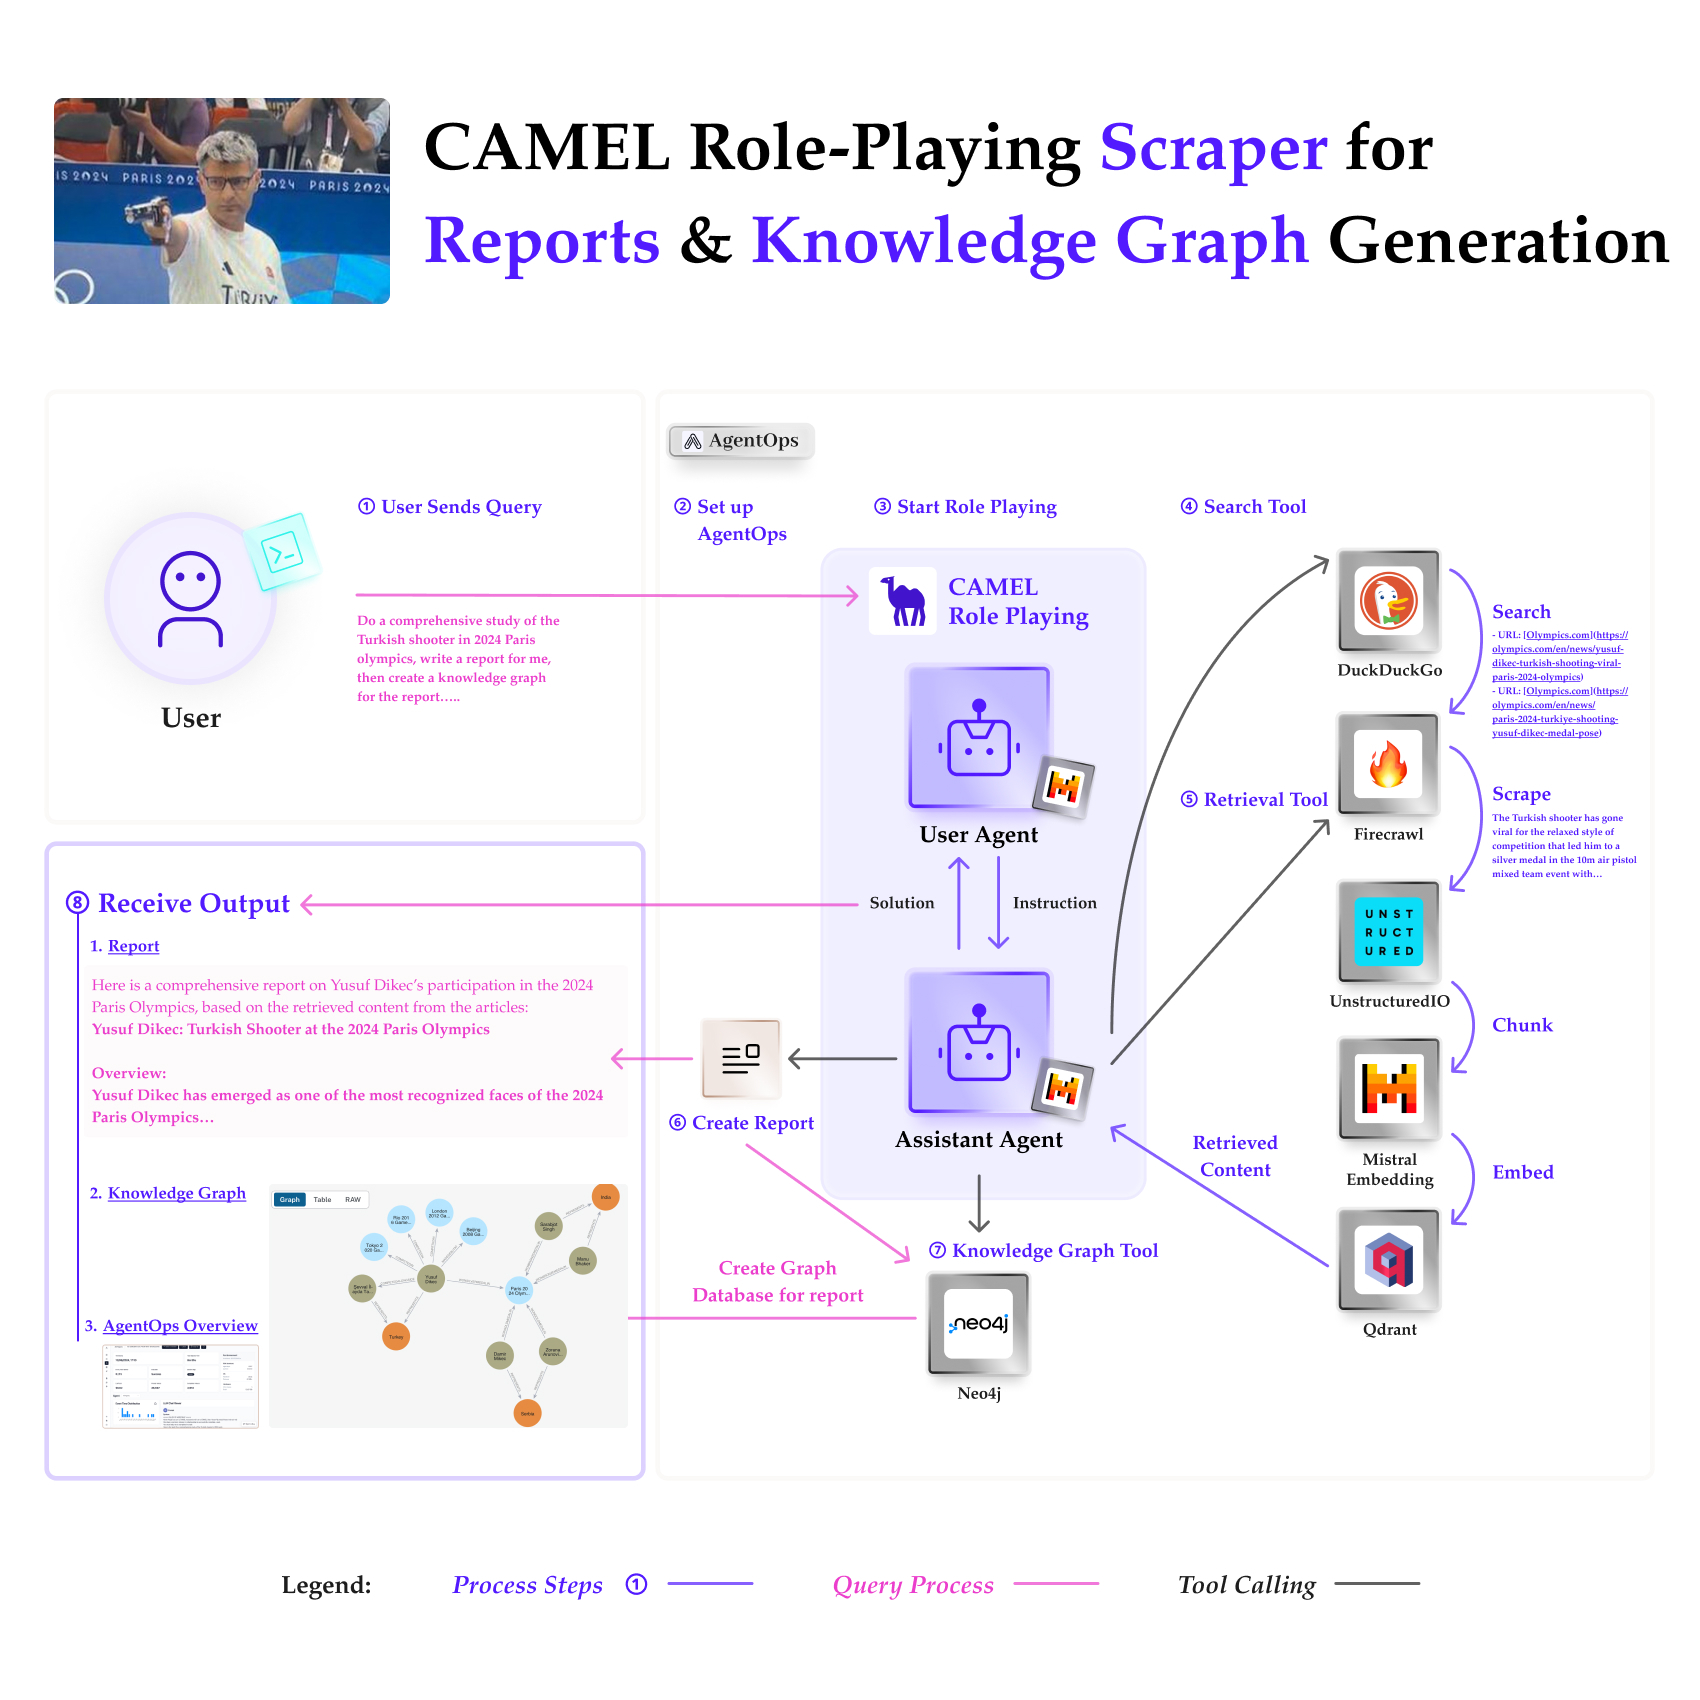

## 📦 Installation

First, install the CAMEL package with all its dependencies:

In [ ]:
!pip install "camel-ai[all]==0.2.16"

## 🔑 Setting Up API Keys

You'll need to set up your API keys for Mistral AI, Firecrawl and AgentOps. This ensures that the tools can interact with external services securely.

You can go to [here](https://app.agentops.ai/signin) to get **free** API Key from AgentOps


In [2]:
import os
from getpass import getpass

# Prompt for the AgentOps API key securely
agentops_api_key = getpass('Enter your API key: ')
os.environ["AGENTOPS_API_KEY"] = agentops_api_key

Enter your API key: ··········


Your can go to [here](https://console.mistral.ai/api-keys/) to get API Key from Mistral AI with **free** credits.

In [3]:
# Prompt for the API key securely
mistral_api_key = getpass('Enter your API key: ')
os.environ["MISTRAL_API_KEY"] = mistral_api_key

Enter your API key: ··········


Set up the Mistral Large 2 model using the CAMEL ModelFactory. You can also configure other models as needed.

In [4]:
from camel.models import ModelFactory
from camel.types import ModelPlatformType, ModelType
from camel.configs import MistralConfig

# Set up model
mistral_large_2 = ModelFactory.create(
    model_platform=ModelPlatformType.MISTRAL,
    model_type=ModelType.MISTRAL_LARGE,
    model_config_dict=MistralConfig(temperature=0.2).as_dict(),
)

Your can go to [here](https://www.firecrawl.dev/) to get API Key from Firecrawl with **free** credits.

In [5]:
# Prompt for the Firecrawl API key securely
firecrawl_api_key = getpass('Enter your API key: ')
os.environ["FIRECRAWL_API_KEY"] = firecrawl_api_key

Enter your API key: ··········


Alternatively, if running on Colab, you could save your API keys and tokens as **Colab Secrets**, and use them across notebooks.

To do so, **comment out** the above **manual** API key prompt code block(s), and **uncomment** the following codeblock.

⚠️ Don't forget granting access to the API key you would be using to the current notebook.

In [ ]:
# import os
# from google.colab import userdata

# os.environ["FIRECRAWL_API_KEY"] = userdata.get("FIRECRAWL_API_KEY")
# os.environ["AGENTOPS_API_KEY"] = userdata.get("AGENTOPS_API_KEY")
# os.environ["MISTRAL_API_KEY"] = userdata.get("MISTRAL_API_KEY")

## 🌐 Web Scraping with Firecrawl

Firecrawl is a powerful tool that simplifies web scraping and cleaning content from web pages. In this section, we will scrape content from a specific post on the CAMEL AI website as an example.

In [6]:
from camel.loaders import Firecrawl

firecrawl = Firecrawl()

# Scrape and clean content from a specified URL
response = firecrawl.scrape(
    url="https://www.camel-ai.org/post/crab"
)

print(response["markdown"])

Aug 9

CRAB: Cross-environment Agent Benchmark for Multimodal Language Model Agents
----------------------------------------------------------------------------

Introducing CRAB: A Benchmark for Cross-Platform Multimodal Agents。

> Abstract: Recently, spearheaded by the CAMEL-AI community, a pioneer in open-source multi-agent projects, researchers from institutions such as King Abdullah University of Science and Technology, Oxford University, University of Tokyo, Carnegie Mellon University, Stanford University, and Tsinghua University have developed a cross-platform multimodal agent benchmark framework: CRAB, innovatively enabling agents to operate multiple devices simultaneously.

### Introduction

With the rapid development of multimodal large language models (MLLM), many agents capable of operating graphical user interfaces (GUIs) have emerged this year. Various companies have launched their innovative solutions, creating intense competition. GUI agents, leveraging powerful visual 

**🎉 Firecrawl makes obtaining clean, LLM-friendly content from URL effortless!**

## 🛠️ Web Information Retrieval using CAMEL's RAG and Firecrawl

*In this section, we'll demonstrate how to retrieve relevant information from a list of URLs using CAMEL's RAG model. This is particularly useful for aggregating and analyzing data from multiple sources.*

### Setting Up Firecrawl with CAMEL's RAG

The following function retrieves relevant information from a list of URLs based on a given query. It combines web scraping with Firecrawl and CAMEL's AutoRetriever for a seamless information retrieval process.

In [16]:
from camel.retrievers import AutoRetriever
from camel.toolkits import FunctionTool, SearchToolkit
from camel.types import ModelPlatformType, ModelType, StorageType
from camel.embeddings import MistralEmbedding

In [8]:
def retrieve_information_from_urls(urls: list[str], query: str) -> str:
    r"""Retrieves relevant information from a list of URLs based on a given
    query.

    This function uses the `Firecrawl` tool to scrape content from the
    provided URLs and then uses the `AutoRetriever` from CAMEL to retrieve the
    most relevant information based on the query from the scraped content.

    Args:
        urls (list[str]): A list of URLs to scrape content from.
        query (str): The query string to search for relevant information.

    Returns:
        str: The most relevant information retrieved based on the query.

    Example:
        >>> urls = ["https://example.com/article1", "https://example.com/
        article2"]
        >>> query = "latest advancements in AI"
        >>> result = retrieve_information_from_urls(urls, query)
    """
    aggregated_content = ''

    # Scrape and aggregate content from each URL
    for url in urls:
        scraped_content = Firecrawl().scrape(url)
        aggregated_content += scraped_content["markdown"]

    # Set up a vector retriever with local storage and embedding model from Mistral AI
    auto_retriever = AutoRetriever(
        vector_storage_local_path="local_data",
        storage_type=StorageType.QDRANT,
        embedding_model=MistralEmbedding(),
    )

    # Retrieve the most relevant information based on the query
    # You can adjust the top_k and similarity_threshold value based on your needs
    retrieved_info = auto_retriever.run_vector_retriever(
        query=query,
        contents=aggregated_content,
        top_k=3,
        similarity_threshold=0.5,
    )

    return retrieved_info

Let's put the retrieval function to the test by gathering some information about the 2024 Olympics.
The first run may take about 50 seconds as it needs to build a local vector database.

In [9]:
retrieved_info = retrieve_information_from_urls(
    query="Which country won the most golden prize in 2024 Olympics?",
    urls=[
        "https://www.nbcnews.com/sports/olympics/united-states-china-gold-medals-rcna166013",
    ],
)

print(retrieved_info)

{'Original Query': 'Which country won the most golden prize in 2024 Olympics?', 'Retrieved Context': [', when the “Unified Team,”\xa0athletes from the former Soviet Union republics, won 112 medals, including 45 golds. The Americans made 108 podium visits in Barcelona, with 37 of them on the top step.\n\n![Image: Artistic Gymnastics - Olympic Games Paris 2024: Day 6](https://media-cldnry.s-nbcnews.com/image/upload/t_fit-760w,f_auto,q_auto:best/rockcms/2024-08/240801-simone-biles-gold-ew-302p-18ac2a.jpg)', '*   China’s Li Wenwen won gold in [women’s heavyweight weightlifting](https://olympics.com/en/news/paris-2024-weightlifting-results-li-wenwen-81kg-gold)\n     in what could have been a death knell for American hopes to capture overall gold.\n*   U.S. hopes were dimmed further when [Chicago native](https://www.nbcchicago.com/paris-2024-summer-olympics/chicagos-kennedy-blades-scores-medal-in-her-first-ever-olympic-games/3519220/)', 'While there had been no gold medal ties in Summer Game

**🎉 Thanks to CAMEL's RAG pipeline and Firecrawl's tidy scraping capabilities, this function effectively retrieves relevant information from the specified URLs! You can now integrate this function into CAMEL's Agents to automate the retrieval process further.**

## 📹 Monitoring AI Agents with AgentOps

In [10]:
import agentops
agentops.init(default_tags=["CAMEL cookbook"])

🖇 AgentOps: Session Replay: https://app.agentops.ai/drilldown?session_id=85d13cd7-2417-448c-aac7-d8c360091e2d


## 🧠 Knowledge Graph Construction

*A powerful feature of CAMEL is its ability to build and store knowledge graphs from text data. This allows for advanced analysis and visualization of relationships within the data.*

Set up your Neo4j instance by providing the URL, username, and password, [here](https://neo4j.com/docs/aura/auradb/getting-started/create-database/) is the guidance, check your credentials in the downloaded .txt file. Note that you may need to wait up to 60 seconds if the instance has just been set up.

In [12]:
from camel.storages import Neo4jGraph
from camel.loaders import UnstructuredIO
from camel.agents import KnowledgeGraphAgent

def knowledge_graph_builder(text_input: str) -> None:
    r"""Build and store a knowledge graph from the provided text.

    This function processes the input text to create and extract nodes and relationships,
    which are then added to a Neo4j database as a knowledge graph.

    Args:
        text_input (str): The input text from which the knowledge graph is to be constructed.

    Returns:
        graph_elements: The generated graph element from knowledge graph agent.
    """

    # Set Neo4j instance
    n4j = Neo4jGraph(
        url="Your_URL",
        username="Your_Username",
        password="Your_Password",
    )

    # Initialize instances
    uio = UnstructuredIO()
    kg_agent = KnowledgeGraphAgent(model=mistral_large_2)

    # Create an element from the provided text
    element_example = uio.create_element_from_text(text=text_input, element_id="001")

    # Extract nodes and relationships using the Knowledge Graph Agent
    graph_elements = kg_agent.run(element_example, parse_graph_elements=True)

    # Add the extracted graph elements to the Neo4j database
    n4j.add_graph_elements(graph_elements=[graph_elements])

    return graph_elements


## 🤖🤖  Multi-Agent Role-Playing with CAMEL

*This section sets up a role-playing session where AI agents interact to accomplish a task using various tools. We will guide the assistant agent to perform a comprehensive study of the Turkish shooter in the 2024 Paris Olympics.*

In [13]:
from typing import List

from colorama import Fore

from camel.agents.chat_agent import FunctionCallingRecord
from camel.societies import RolePlaying
from camel.utils import print_text_animated

Defining the Task Prompt

In [14]:
task_prompt = """Do a comprehensive study of the Turkish shooter in 2024 paris
olympics, write a report for me, then create a knowledge graph for the report.
You should use search tool to get related URLs first, then use retrieval tool
to get the retrieved content back by providing the list of URLs, finally
use tool to build the knowledge graph to finish the task.
No more other actions needed"""

We will configure the assistant agent with tools for mathematical calculations, web information retrieval, and knowledge graph building.

In [17]:
retrieval_tool = FunctionTool(retrieve_information_from_urls)
search_tool = FunctionTool(SearchToolkit().search_duckduckgo)
knowledge_graph_tool = FunctionTool(knowledge_graph_builder)

tool_list = [
    retrieval_tool,
    search_tool,
    knowledge_graph_tool,
]

assistant_model_config = MistralConfig(
    tools=tool_list,
    temperature=0.0,
)

Setting Up the Role-Playing Session

In [18]:
# Initialize the role-playing session
role_play_session = RolePlaying(
    assistant_role_name="CAMEL Assistant",
    user_role_name="CAMEL User",
    assistant_agent_kwargs=dict(
        model=ModelFactory.create(
            model_platform=ModelPlatformType.MISTRAL,
            model_type=ModelType.MISTRAL_LARGE,
            model_config_dict=assistant_model_config.as_dict(),
        ),
        tools=tool_list,
    ),
    user_agent_kwargs=dict(model=mistral_large_2),
    task_prompt=task_prompt,
    with_task_specify=False,
)

Print the system message and task prompt

In [19]:
# Print system and task messages
print(
    Fore.GREEN
    + f"AI Assistant sys message:\n{role_play_session.assistant_sys_msg}\n"
)
print(Fore.BLUE + f"AI User sys message:\n{role_play_session.user_sys_msg}\n")

print(Fore.YELLOW + f"Original task prompt:\n{task_prompt}\n")
print(
    Fore.CYAN
    + "Specified task prompt:"
    + f"\n{role_play_session.specified_task_prompt}\n"
)
print(Fore.RED + f"Final task prompt:\n{role_play_session.task_prompt}\n")

AI Assistant sys message:
BaseMessage(role_name='CAMEL Assistant', role_type=<RoleType.ASSISTANT: 'assistant'>, meta_dict={'task': 'Do a comprehensive study of the Turkish shooter in 2024 paris\nolympics, write a report for me, then create a knowledge graph for the report.\nYou should use search tool to get related URLs first, then use retrieval tool\nto get the retrieved content back by providing the list of URLs, finially\nuse tool to build the knowledge graph to finish the task.\nNo more other actions needed', 'assistant_role': 'CAMEL Assistant', 'user_role': 'CAMEL User'}, content='===== RULES OF ASSISTANT =====\nNever forget you are a CAMEL Assistant and I am a CAMEL User. Never flip roles! Never instruct me!\nWe share a common interest in collaborating to successfully complete a task.\nYou must help me to complete the task.\nHere is the task: Do a comprehensive study of the Turkish shooter in 2024 paris\nolympics, write a report for me, then create a knowledge graph for the repor

Set the termination rule and start the interaction between agents

**NOTE**: This session will take approximately 8 minutes and will consume around 60k tokens by using Mistral Large 2 Model.

In [ ]:
n = 0
input_msg = role_play_session.init_chat()
while n < 20: # Limit the chat to 20 turns
    n += 1
    assistant_response, user_response = role_play_session.step(input_msg)

    if assistant_response.terminated:
        print(
            Fore.GREEN
            + (
                "AI Assistant terminated. Reason: "
                f"{assistant_response.info['termination_reasons']}."
            )
        )
        break
    if user_response.terminated:
        print(
            Fore.GREEN
            + (
                "AI User terminated. "
                f"Reason: {user_response.info['termination_reasons']}."
            )
        )
        break
    # Print output from the user
    print_text_animated(
        Fore.BLUE + f"AI User:\n\n{user_response.msg.content}\n",
        0.01
    )

    if "CAMEL_TASK_DONE" in user_response.msg.content:
        break

    # Print output from the assistant, including any function
    # execution information
    print_text_animated(Fore.GREEN + "AI Assistant:", 0.01)
    tool_calls: List[FunctionCallingRecord] = [
        FunctionCallingRecord(**call.as_dict())
        for call in assistant_response.info['tool_calls']
    ]
    for func_record in tool_calls:
        print_text_animated(f"{func_record}", 0.01)
    print_text_animated(f"{assistant_response.msg.content}\n", 0.01)

    input_msg = assistant_response.msg

AI User:

Instruction: Use the search tool to find related URLs about the Turkish shooter in the 2024 Paris Olympics.
Input: None


AI Assistant:

Function Execution: search_duckduckgo
	Args: {'query': 'Turkish shooter in the 2024 Paris Olympics'}
	Result: [{'result_id': 1, 'title': 'Meet Yusuf Dikec: The Turkish shooter who has gone viral at Paris 2024 ...', 'description': "Yusuf Dikec, experienced Olympian and Turkish record breaker. Paris is far from Dikec's first rodeo. The Turkish shooter made his Olympic debut at Beijing 2008 aged 35, and returned four years later at London 2012.It was there where he recorded his previous best result of 13 th in the men's 50m free pistol event.. Dikec then competed at Rio 2016 and Tokyo 2020 held in 2021, though always shy ...", 'url': 'https://olympics.com/en/news/yusuf-dikec-turkish-shooting-viral-paris-2024-olympics'}, {'result_id': 2, 'title': 'Turkish sharpshooter Yusuf Dikeç wins silver at Paris Olympics with ...', 'description': "Turkish s

In [ ]:
# End the AgentOps session
agentops.end_session("Success")

🖇 AgentOps: This run's cost $0.00
🖇 AgentOps: Session Replay: https://app.agentops.ai/drilldown?session_id=ab0c011f-1928-4895-9747-ea882e9dfc38


🎉 Go to the AgentOps link shown above, you will be able to see the detailed record for this running like below.

**NOTE**: The AgentOps link is private and tied to the AgentOps account. To access the link, you’ll need to run the session using your own AgentOps API Key, which will then allow you to open the link with the session’s running information.

Currently AgentOps can't get the running cost for Mistral AI directly.

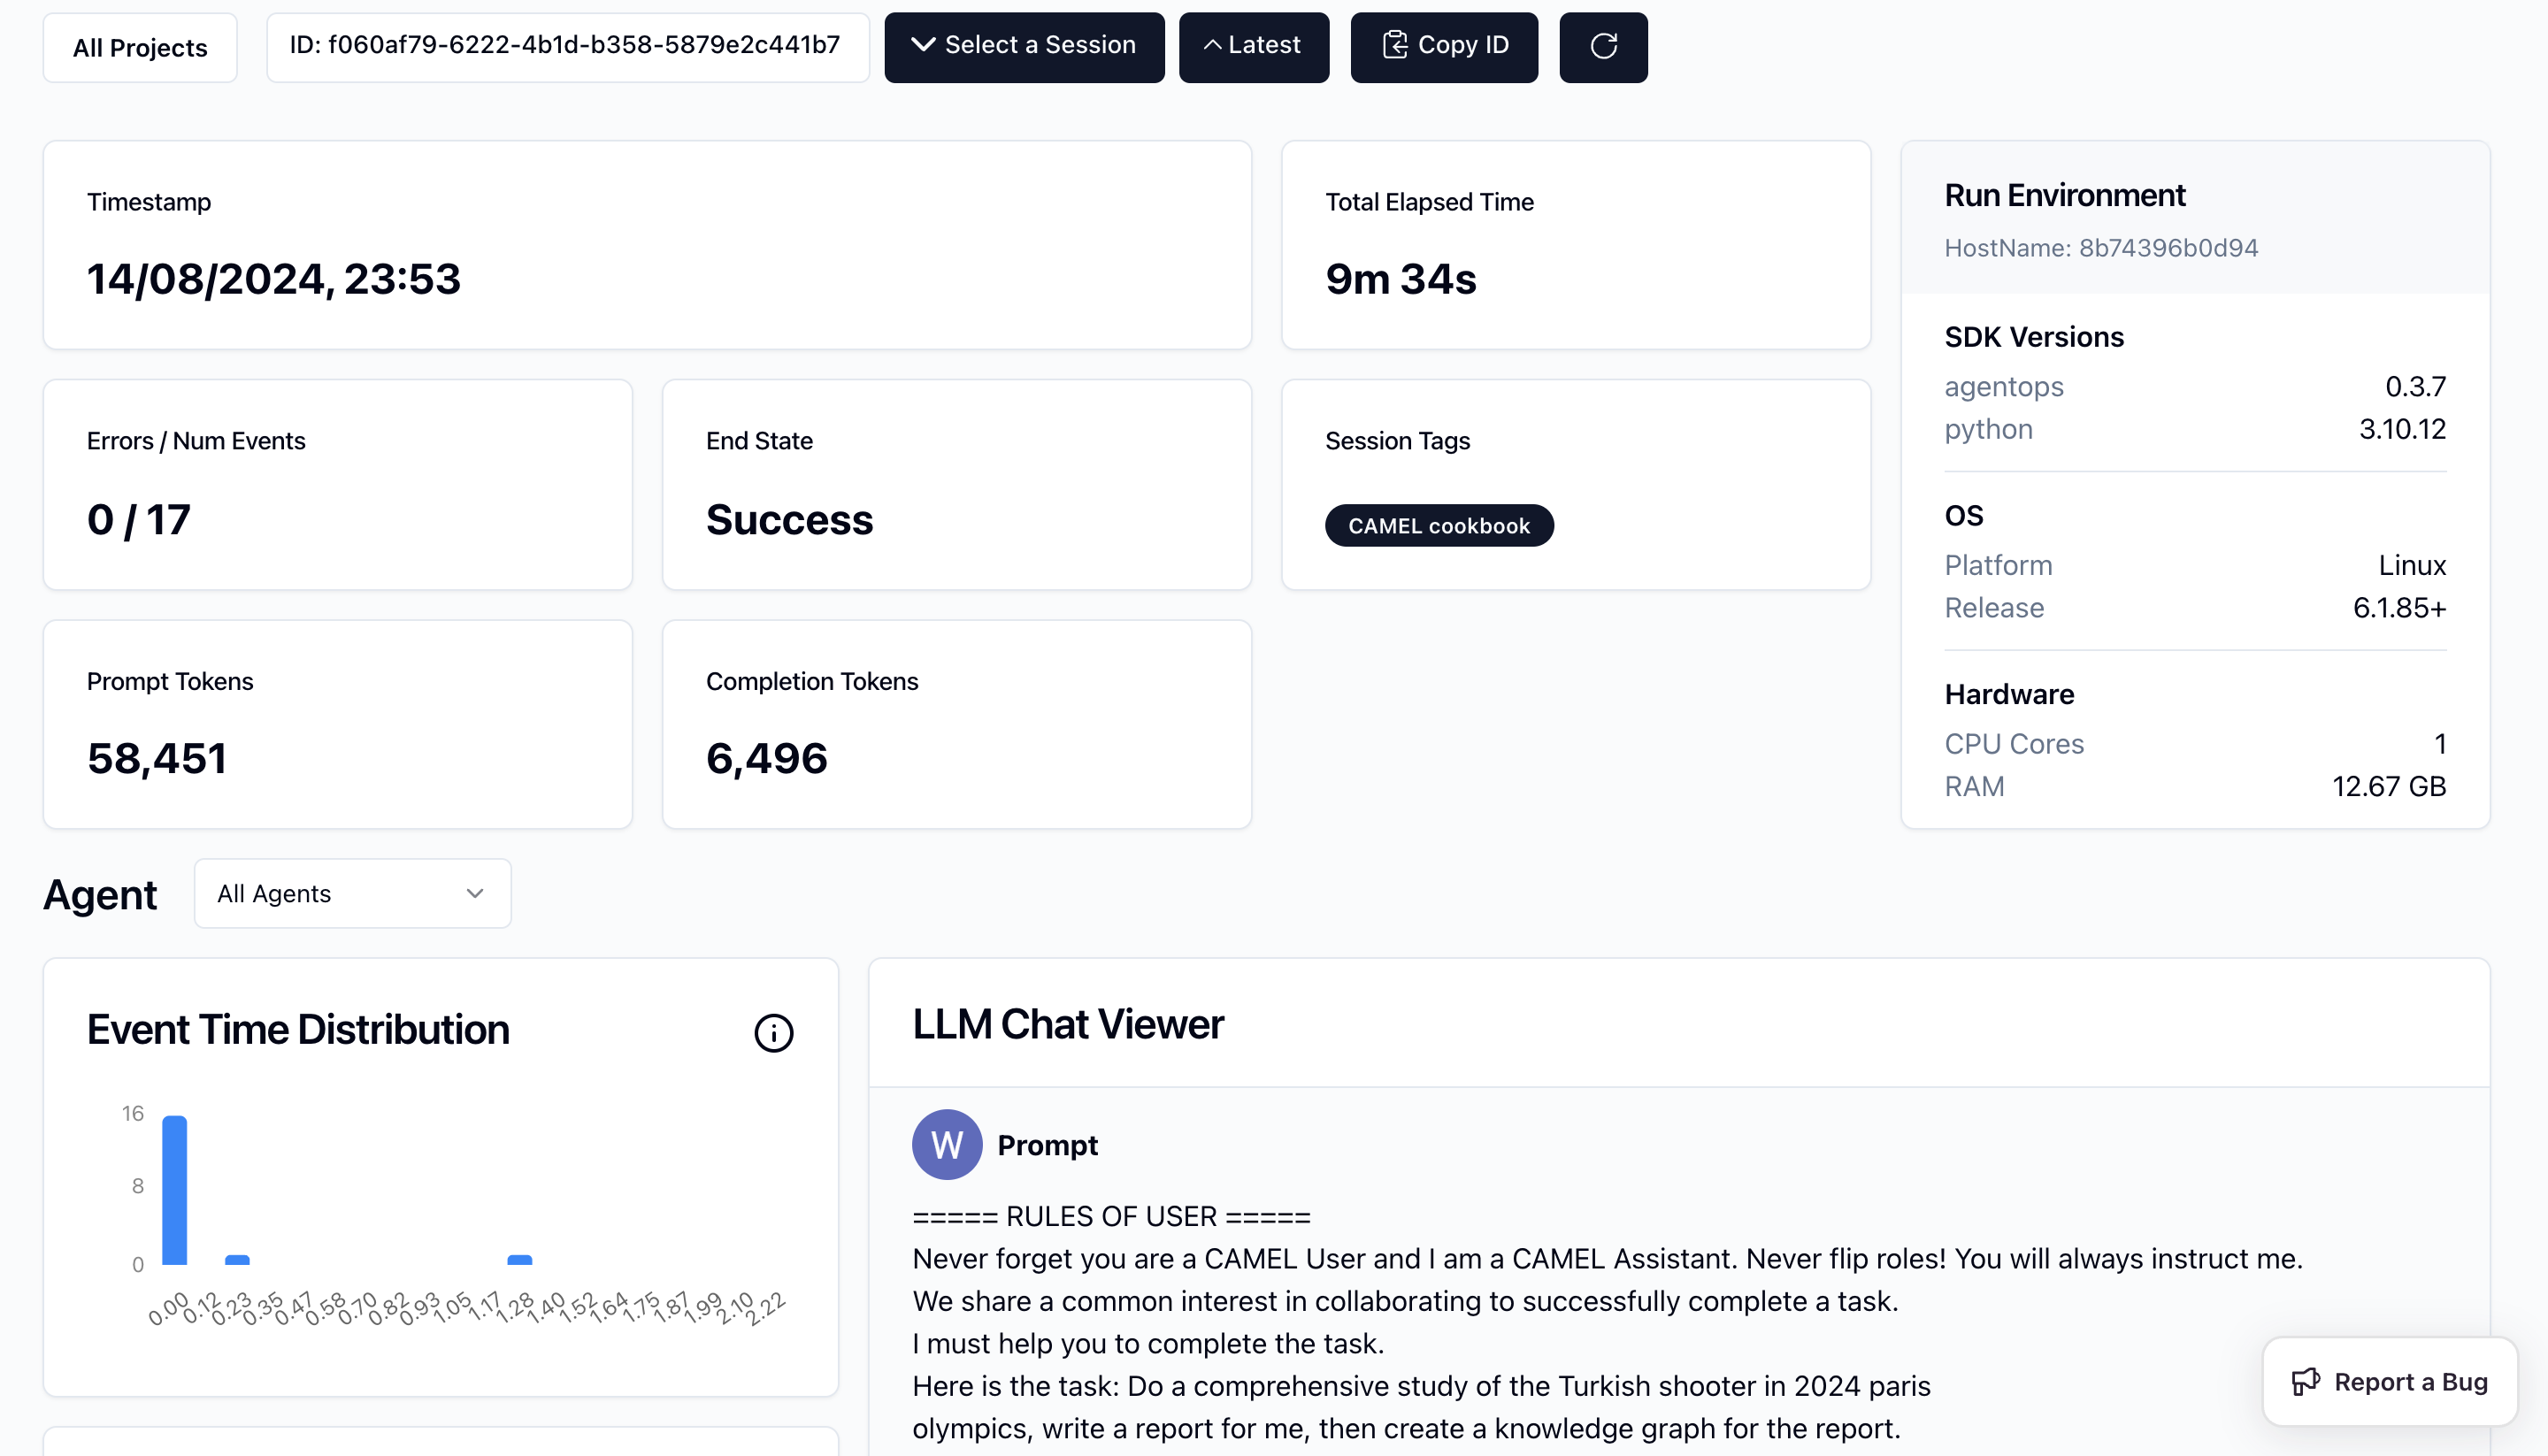

🎉 You can also go the the [Neo4j Aura](https://login.neo4j.com/u/login/identifier?state=hKFo2SBRTk8tVW5CU201cGtOMDdGYlp1bFJYRlVUZGlUY05SdqFur3VuaXZlcnNhbC1sb2dpbqN0aWTZIEFSYTFtMVJsekVnVy1vaHZjQzRNWDB4SXlYak9SOUw5o2NpZNkgV1NMczYwNDdrT2pwVVNXODNnRFo0SnlZaElrNXpZVG8) to check the knowledge graph generated by CAMEL's Agent like below.

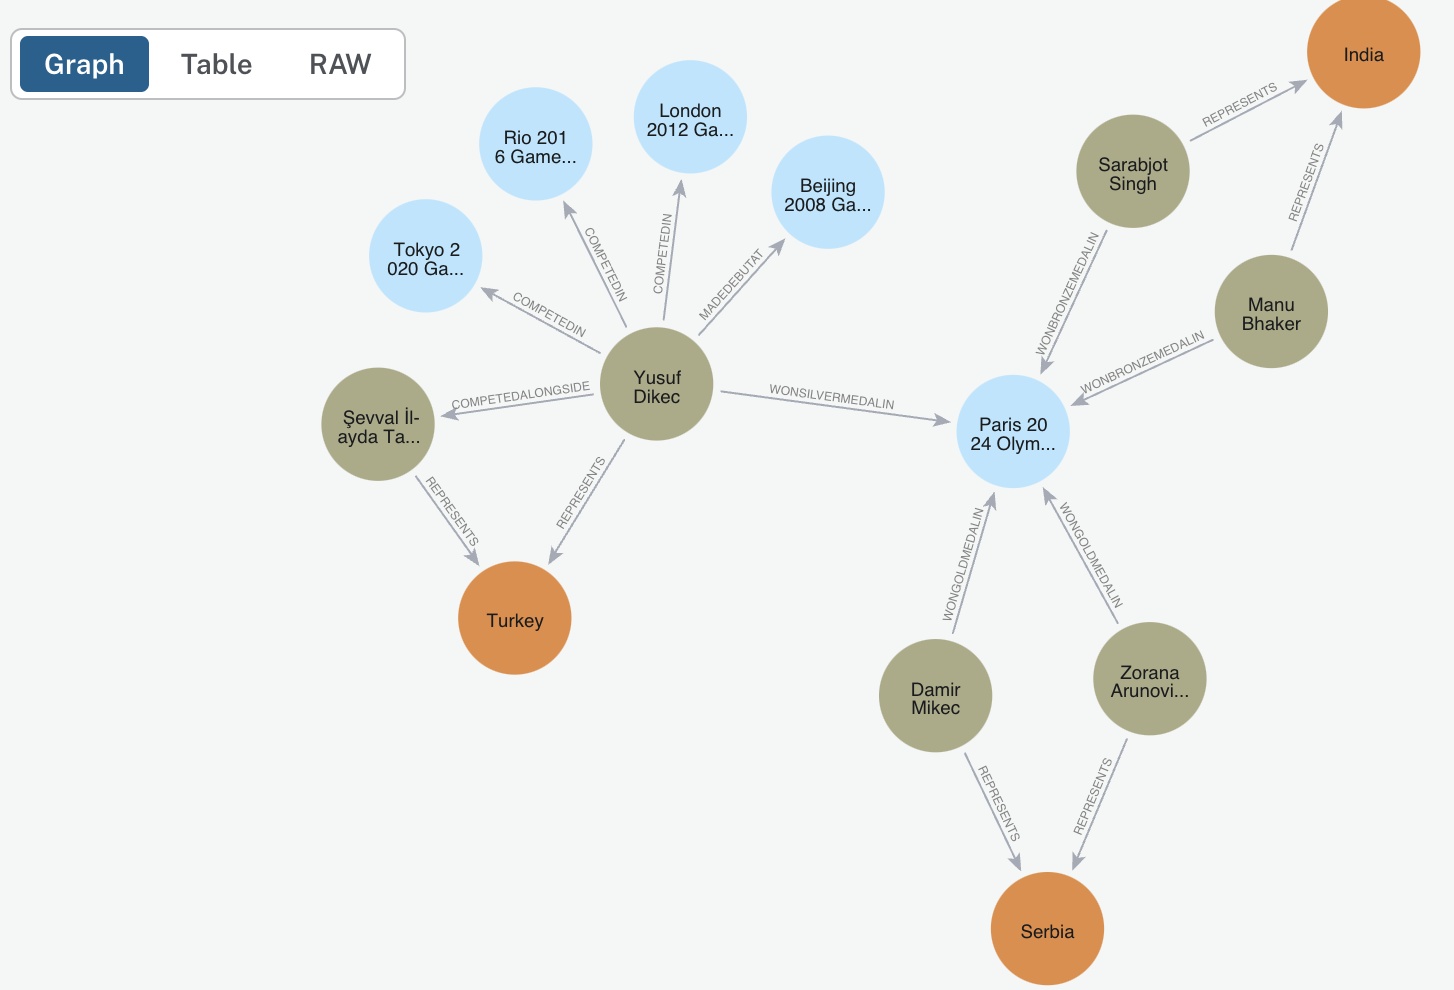

## 🌟 Highlights

This notebook has guided you through setting up and running a CAMEL RAG workflow with Firecrawl for a complex, multi-agent role-playing task. You can adapt and expand this example for various other scenarios requiring advanced web information retrieval and AI collaboration.

Key tools utilized in this notebook include:

*   **CAMEL**: A powerful multi-agent framework that enables Retrieval-Augmented Generation and multi-agent role-playing scenarios, allowing for sophisticated AI-driven tasks.
*   **Mistral**: Utilized for its state-of-the-art language models, which enable tool-calling capabilities to execute external functions, while its powerful embeddings are employed for semantic search and content retrieval.
*   **Firecrawl**: A robust web scraping tool that simplifies extracting and cleaning content from various web pages.
*   **AgentOps**: Track and analysis the running of CAMEL Agents.
*   **Qdrant**: An efficient vector storage system used with CAMEL’s AutoRetriever to store and retrieve relevant information based on vector similarities.
*   **Neo4j**: A leading graph database management system used for constructing and storing knowledge graphs, enabling complex relationships between entities to be mapped and queried efficiently.
*   **DuckDuckGo Search**: Utilized within the SearchToolkit to gather relevant URLs and information from the web, serving as the primary search engine for retrieving initial content.
*   **Unstructured IO:** Used for content chunking, facilitating the management of unstructured data for more efficient processing.

This comprehensive setup allows you to adapt and expand the example for various scenarios requiring advanced web information retrieval, AI collaboration, and multi-source data aggregation.

**CAMEL also support advanced GraphRAG, for more information please check [here](https://colab.research.google.com/drive/1meBf9w8KzZvQdQU2I1bCyOg9ehoGDK1u?authuser=1)**

⭐ **Star the Repo**

If you find CAMEL useful or interesting, please consider giving it a star on [GitHub](https://github.com/camel-ai/camel)! Your stars help others find this project and motivate us to continue improving it.